<a href="https://www.kaggle.com/ppjanka/2021-commonlitreadability?scriptVersionId=86418794" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
random_state = 0
force_retune = False
use_augmentation = True

import re # regex
from tqdm import tqdm
import pickle as pkl

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# a bunch of scalers to try
# from: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, Normalizer

# a bunch of classical ML regressors to try
# list from: https://www.educative.io/blog/scikit-learn-cheat-sheet-classification-regression-methods
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from string import punctuation

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import keras_tuner as kt
from tensorflow.keras.backend import stop_gradient

import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import glob
print(glob.glob('/kaggle/working/*'))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.200d.txt
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.50d.txt
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.300d.txt
/kaggle/input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin
/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.100d.txt
/kaggle/input/commonlitreadabilityprize/sample_submission.csv
/kaggle/input/commonlitreadabilityprize/train.csv
/kaggle/input/commonlitreadabilityprize/test.csv
/kaggle/input/english-word-frequency/unigram_freq.csv
['/kaggle/working/__notebook__.ipynb']


In [2]:
data = pd.read_csv('/kaggle/input/commonlitreadabilityprize/train.csv')
data.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2834 non-null   object 
 1   url_legal       830 non-null    object 
 2   license         830 non-null    object 
 3   excerpt         2834 non-null   object 
 4   target          2834 non-null   float64
 5   standard_error  2834 non-null   float64
dtypes: float64(2), object(4)
memory usage: 133.0+ KB


In [4]:
print(data.dtypes)

id                 object
url_legal          object
license            object
excerpt            object
target            float64
standard_error    float64
dtype: object


In [5]:
# drop url_legal, unique -- they are not in the test dataset, and do not look useful anyways
data.drop(['url_legal', 'license'], axis=1, inplace=True)

noTrain_columns = ['target','standard_error','excerpt','id']

In [6]:
# data preprocessing
def split_data (df, target='target', test_size=0.2, pca=False, indices=None, augmented=False):
    if pca:
        pca = PCA()
        pca_cols = pca.fit_transform(
            data[data.columns.difference(noTrain_columns)])
        X = pd.DataFrame(data=pca_cols,
            columns=['PCA%i' % i for i in range(pca_cols.shape[1])])
    else:
        X = df[df.columns.difference(noTrain_columns)]
        
    if augmented:
        y = df[[target,'standard_error']].to_numpy()
    else:
        y = df[target]
    if indices == None:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    else:
        train_indices, test_indices = indices
        X_train = X.iloc[train_indices]
        X_test = X.iloc[test_indices]
        if augmented:
            y_train = y[train_indices]
            y_test = y[test_indices]
        else:
            y_train = y.iloc[train_indices]
            y_test = y.iloc[test_indices]
    return X_train, X_test, y_train, y_test, pca

In [7]:
# Baseline model
def try_SGDR (data, pca=False, indices=None, output=False):
    X_train, X_test, y_train, y_test, pca = split_data(data, pca=pca, indices=indices)
    reg = make_pipeline(StandardScaler(),
                        SGDRegressor(random_state=random_state))
    reg.fit(X_train, y_train)
    print("RMSE: ", mean_squared_error(y_test, reg.predict(X_test), squared=False))
    if output:
        return reg

In [8]:
# Generate the most basic features
data['no_lineBreaks'] = data['excerpt'].str.split('\n').transform(len)
data['no_sentences'] = data['excerpt'].str.split('.').transform(len)
data['no_words'] = data['excerpt'].str.split(' ').transform(len)
data['no_characters'] = data['excerpt'].apply(len)
data.head()

,id,excerpt,target,standard_error,no_lineBreaks,no_sentences,no_words,no_characters
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009,6,12,174,992
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,6,11,164,937
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,5,12,162,908
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007,2,6,163,909
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845,1,6,147,723


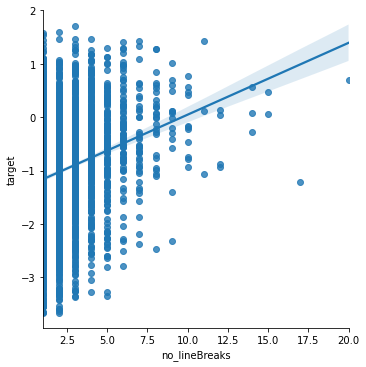

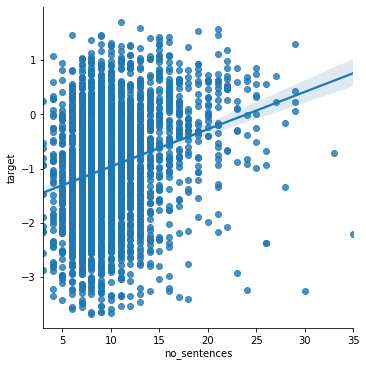

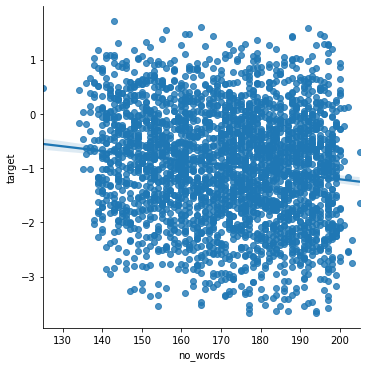

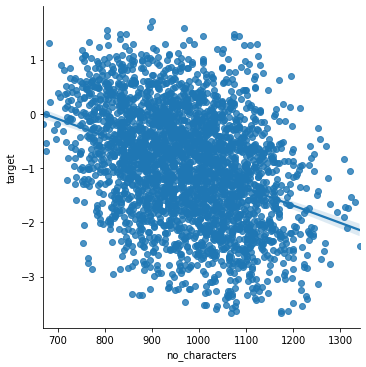

In [9]:
sns.lmplot(data=data, x='no_lineBreaks', y='target')
sns.lmplot(data=data, x='no_sentences', y='target')
sns.lmplot(data=data, x='no_words', y='target')
sns.lmplot(data=data, x='no_characters', y='target')

In [10]:
try_SGDR(data)

RMSE:  0.8754661157439219


In [11]:
# potentially useful mean ratios
data['mean_sentences_per_lineBreak'] = data['no_sentences'] / data['no_lineBreaks']
data['mean_words_per_sentence'] = data['no_words'] / data['no_sentences']
data['mean_characters_per_word'] = data['no_characters'] / data['no_words']
try_SGDR(data)

RMSE:  0.8712976893462789


In [12]:
# potentially useful min/max ratios
sentences_per_lineBreak = data.excerpt.str.split('\n').transform(lambda x : [len(y.split('.')) for y in x])
data['min_sentences_per_lineBreak'] = sentences_per_lineBreak.apply(min)
data['max_sentences_per_lineBreak'] = sentences_per_lineBreak.apply(max)
del sentences_per_lineBreak

lineBreaks_per_sentence = data.excerpt.str.split('.').transform(lambda x : [len(y.split('\n')) for y in x])
data['min_lineBreaks_per_sentence'] = lineBreaks_per_sentence.apply(min)
data['max_lineBreaks_per_sentence'] = lineBreaks_per_sentence.apply(max)
del lineBreaks_per_sentence

words_per_sentence = data.excerpt.str.split('.').transform(lambda x : [len(y.split(' ')) for y in x])
data['min_words_per_sentence'] = words_per_sentence.apply(min)
data['max_words_per_sentence'] = words_per_sentence.apply(max)
del words_per_sentence

words_per_lineBreak = data.excerpt.str.split('\n').transform(lambda x : [len(y.split(' ')) for y in x])
data['min_words_per_lineBreak'] = words_per_lineBreak.apply(min)
data['max_words_per_lineBreak'] = words_per_lineBreak.apply(max)
del words_per_lineBreak
    
characters_per_word = data.excerpt.str.split(' ').transform(lambda x : [len(y) for y in x])
data['min_characters_per_word'] = characters_per_word.apply(min)
data['max_characters_per_word'] = characters_per_word.apply(max)
del characters_per_word

characters_per_sentence = data.excerpt.str.split('.').transform(lambda x : [len(y) for y in x])
data['min_characters_per_sentence'] = characters_per_sentence.apply(min)
data['max_characters_per_sentence'] = characters_per_sentence.apply(max)
del characters_per_sentence

characters_per_lineBreak = data.excerpt.str.split('\n').transform(lambda x : [len(y) for y in x])
data['min_characters_per_lineBreak'] = characters_per_lineBreak.apply(min)
data['max_characters_per_lineBreak'] = characters_per_lineBreak.apply(max)
del characters_per_lineBreak

try_SGDR(data)

RMSE:  0.856364733820838


In [13]:
# punctuation marks count in the text
difficult_punctuation = ";\"'‘“:-()[]+?!$&/"
data['punctuation_count'] = data.excerpt.apply(lambda x : sum([c in difficult_punctuation for c in x]))
data['punctuation_frequency'] = data['punctuation_count'] / data['no_characters']
try_SGDR(data)

RMSE:  0.8523844871434775


In [14]:
# numbers might indicate a text of technical nature, thus more difficult
number_characters = "0123456789"
data['number_count'] = data.excerpt.apply(lambda x : sum([c in number_characters for c in x]))
data['number_frequency'] = data['number_count'] / data['no_characters']
try_SGDR(data)

RMSE:  0.8484176603178444


In [15]:
# multiple letters might indicate colloquial speech, e.g., aahh, oooh, etc.
def count_repeated_characters (word):
    chars = np.array(list(word))
    return np.sum(chars[1:] == chars[:-1])
data['multiple_count'] = data.excerpt.apply(count_repeated_characters)
data['multiple_count_frequency'] = data['multiple_count'] / data['no_characters']
try_SGDR(data)

RMSE:  0.8485189197352265


In [16]:
# try with PCA features
try_SGDR(data, pca=True)

RMSE:  0.8527001023829955


Adding min/max ratios gave us a slight improvement, but otherwise it seems that not much more can be done with simple count statistics of the text.. It's time to start working with text comprehension.

In [17]:
# start with something simple: 
# create a list of all words in the training dataset, 
# then save frequency of each, and use that to assess difficulty

# create a word list for each excerpt,
# remove punctuation and change to lowercase
data['word_list'] = data.excerpt.apply(lambda x : re.findall("[a-zA-Z]+", x.lower()))
if 'word_list' not in noTrain_columns:
    noTrain_columns += ['word_list',]
    
if False: # either calculate word frequency from the (training) dataset, or use an external database
    # explode each word list into rows
    word_list = pd.DataFrame({'word':data['word_list'].explode(ignore_index=True)})
    # count the occurence frequency
    n_words = word_list.shape[0]
    word_list['count'] = 0
    word_list = word_list.groupby('word').count().sort_values('count', ascending=False)
    word_list /= n_words
else:
    word_list = pd.read_csv('/kaggle/input/english-word-frequency/unigram_freq.csv', dtype={'word':str, 'count':int})
    max_word_length = np.max(word_list.word.apply(lambda x : len(str(x))))
    word_list.set_index('word', inplace=True)
    word_list['count'] /= word_list['count'].sum()
    
max_word_freq = word_list['count'].max()
    
# turn the word_list into a dictionary, a function to handle unknown words too
word_list = word_list.to_dict()['count']
def word_freq (word):
    try:
        return word_list[word]
    except Exception as e:
        return 0.

In [18]:
# now add a mean, min, max frequency of a word in a given excerpt
data['word_frequencies'] = data.word_list.apply(lambda x : [word_freq(y) for y in x])
if 'word_frequencies' not in noTrain_columns:
    noTrain_columns += ['word_frequencies',]
data['mean_word_frequecy'] = data.word_frequencies.apply(np.mean)
data['median_word_frequecy'] = data.word_frequencies.apply(np.median)
data['min_word_frequecy'] = data.word_frequencies.apply(np.min)
data['max_word_frequecy'] = data.word_frequencies.apply(np.max)
data['std_word_frequecy'] = data.word_frequencies.apply(np.std)
try_SGDR(data)

RMSE:  0.8110646455841344


In [19]:
# some words are not in the dictionary, may not be English, or could be made up (zigzzzz, huzzah)
data['non_word_count'] = data.word_frequencies.apply(lambda x : np.sum(np.array(x) == 0))
data['non_word_frequency'] = data['non_word_count'] / data['no_words']
try_SGDR(data)

RMSE:  0.817492956163966


Now, it may be a good idea to take into account relations between nearby words. A convolutional neural network should be great for that. We will use it to generate another column in our feature set.

205


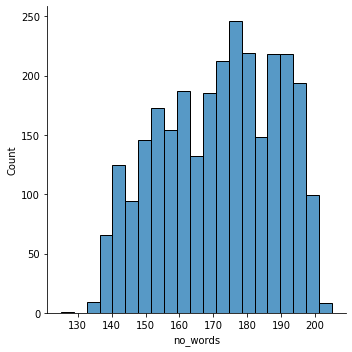

In [20]:
sns.displot(data=data, x='no_words')
print(data['no_words'].max())

In [21]:
# Let's set a constant length of each excerpt, for parsing with NN. If the text is shorter, we will fill it with empty words
WORDS_PER_EXCERPT = 205

In [22]:
# Let's start simple, and first only take into account the length of neighboring words
# (this roughly corresponds to the "rhythm" of the text)

cnn = models.Sequential()
cnn.add(layers.Input(shape=(WORDS_PER_EXCERPT,1)))
cnn.add(layers.Conv1D(4, (4,), activation='relu'))
cnn.add(layers.MaxPooling1D((2,)))
cnn.add(layers.Flatten())
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Dense(16, activation='relu'))
cnn.add(layers.Dropout(0.2))
cnn.add(layers.Dense(8, activation='relu'))
cnn.add(layers.Dense(1))

In [23]:
# To feed the model, use the first WORDS_PER_EXCERPT words of the excerpt.
# If less is available, fill with empty

def nn_preprocess_len (word_list, no_words=WORDS_PER_EXCERPT):
    # cut to the right length
    res = [len(x) for x in word_list]
    if len(res) < no_words:
        res += [0,] * (no_words - len(res))
    else:
        res = res[:no_words]
    res = np.array(res, dtype=np.float)
    # normalize
    res = res * 1.0 / max_word_length
    return res

nn_inputs_len = np.vstack(data.word_list.apply(nn_preprocess_len).to_numpy()).reshape((-1, WORDS_PER_EXCERPT, 1))

In [24]:
# now train the network

# split the data before training, to have the same training sample
# for both SGDR and cnn
X_train, X_test, y_train, y_test, pca = split_data(data, 
                                        pca=False, indices=None)
indices = (y_train.index, y_test.index)

# compile and train the cnn
cnn.compile(optimizer='adam',
           loss=tf.keras.losses.MeanSquaredError(),
           metrics=['RootMeanSquaredError'])

history = cnn.fit(nn_inputs_len[indices[0]], y_train,
                   epochs=10,
                   validation_data=(nn_inputs_len[indices[1]],y_test))

Epoch 1/10
71/71 [==============================] - 7s 12ms/step - loss: 1.3567 - root_mean_squared_error: 1.1583 - val_loss: 0.9715 - val_root_mean_squared_error: 0.9857
Epoch 2/10
71/71 [==============================] - 0s 4ms/step - loss: 0.9741 - root_mean_squared_error: 0.9865 - val_loss: 0.9489 - val_root_mean_squared_error: 0.9741
Epoch 3/10
71/71 [==============================] - 0s 3ms/step - loss: 0.9724 - root_mean_squared_error: 0.9860 - val_loss: 0.9224 - val_root_mean_squared_error: 0.9604
Epoch 4/10
71/71 [==============================] - 0s 4ms/step - loss: 0.9638 - root_mean_squared_error: 0.9815 - val_loss: 0.9289 - val_root_mean_squared_error: 0.9638
Epoch 5/10
71/71 [==============================] - 0s 4ms/step - loss: 0.8975 - root_mean_squared_error: 0.9473 - val_loss: 0.9069 - val_root_mean_squared_error: 0.9523
Epoch 6/10
71/71 [==============================] - 0s 3ms/step - loss: 0.8514 - root_mean_squared_error: 0.9224 - val_loss: 0.8334 - val_root_mean_s

18/18 - 0s - loss: 0.7782 - root_mean_squared_error: 0.8821


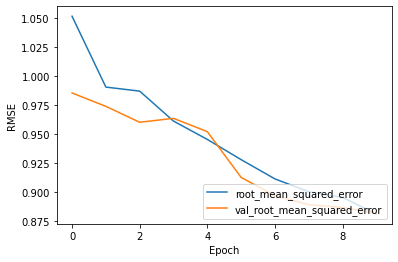

In [25]:
plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend(loc='lower right')

test_loss, test_acc = cnn.evaluate(nn_inputs_len[indices[1]],y_test, verbose=2)

In [26]:
def augmented_loss (loss_instance, y, y_val, sample_weight=None):
    '''This uses the standard_error column to generate a different
    sample from the target distribution at every training step,
    to use for loss calculation.'''
    if y.shape == y_val.shape:
        y_sample = y
    else:
        y_sample = tf.random.normal([1,], y[:,0], y[:,1], y_val.dtype)
    return loss_instance(stop_gradient(y_sample), y_val, sample_weight)

In [27]:
# not bad, but we can do better with some hyperparameter tuning
# Note: this is overcounting a lot of combinations, but it does not seem possible to have the trials conditional in the tuner yet...

def build_cnn_len (hp, augmented=use_augmentation):
    nn = models.Sequential()
    nn.add(layers.Input(shape=(WORDS_PER_EXCERPT,1)))
    num_conv_blocks = hp.Int('conv_blocks', 1,5)
    for i in range(num_conv_blocks):
        with hp.conditional_scope('conv_blocks', list(range(i+1,5+1))): # num > i
            nn.add(layers.Conv1D(hp.Int('filters_conv%i' % i,2,16,step=2),
                (min(nn.output_shape[1], hp.Int('kernel_conv%i' % i,2,16,step=2)),), 
                activation='relu'))
            pooling_choice = hp.Choice('pooling%i' % i, ['avg', 'max', 'none'])
            with hp.conditional_scope('pooling%i' % i, ['avg', 'max']):
                if pooling_choice == 'max':
                    nn.add(layers.MaxPooling1D(
                        (min(nn.output_shape[1], hp.Int('kernel_pool%i' % i,2,8,step=2)),)
                    ))
                elif pooling_choice == 'avg':
                    nn.add(layers.AveragePooling1D(
                        (min(nn.output_shape[1], hp.Int('kernel_pool%i' % i,2,8,step=2)),)
                    ))
            nn.add(layers.Dropout(hp.Float('dropout',0.,0.7,step=0.1)))
    nn.add(layers.Flatten())
    num_dense_blocks = hp.Int('dense_blocks', 1,3)
    for i in range(num_dense_blocks):
        with hp.conditional_scope('dense_blocks', list(range(i+1,3+1))): # num > i
            nn.add(layers.Dropout(hp.Float('dropout',0.,0.7,step=0.1)))
            if hp.Choice('batch_norm', [True, False]):
                nn.add(layers.BatchNormalization())
            nn.add(layers.Dense(hp.Int('dense%i' % i,4,64,step=4), activation='relu'))
    if hp.Choice('batch_norm_output', [True, False]):
        nn.add(layers.BatchNormalization())
    nn.add(layers.Dense(1))
    
    if augmented:
        loss = (lambda y1,y2,w=None : augmented_loss(tf.keras.losses.MeanSquaredError(), y1,y2,w))
    else:
        loss = tf.keras.losses.MeanSquaredError()

    nn.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4,0.3, sampling='log')),
               loss=loss,
               metrics=['RootMeanSquaredError'])
    
    return nn

In [28]:

def fit_from_hp_dict (build_model, hp_dict, 
                      nn_inputs, indices, y_train, y_test, 
                      early_stopping=True, validation=True,
                      epochs=1024):
    '''Using saved HyperParameter.values dict,
    build the tuned model, train it, and plot diagnostics.'''
    best_hyperparameters = kt.HyperParameters()
    best_hyperparameters.values = hp_dict
    best_model = build_model(best_hyperparameters)
    if early_stopping:
        stop_early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=16,
            restore_best_weights=True
        )
        callbacks = [stop_early,]
    else:
        callbacks = []
    if validation:
        validation_data=(nn_inputs[indices[1]],y_test)
    else:
        validation_data=None
    history = best_model.fit(
        nn_inputs[indices[0]], y_train,
        epochs=epochs,
        validation_data=validation_data,
        callbacks=callbacks
    )
    plt.clf()
    plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
    plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend(loc='lower right')
    plt.show()
    plt.close()
    return best_model

Setting hyperparameters to best from previous tuning..
Epoch 1/1024
71/71 [==============================] - 2s 11ms/step - loss: 1.5755 - root_mean_squared_error: 1.3226 - val_loss: 1.7509 - val_root_mean_squared_error: 1.5172
Epoch 2/1024
71/71 [==============================] - 0s 6ms/step - loss: 1.2402 - root_mean_squared_error: 1.3451 - val_loss: 1.2584 - val_root_mean_squared_error: 1.2274
Epoch 3/1024
71/71 [==============================] - 0s 7ms/step - loss: 1.2103 - root_mean_squared_error: 1.2167 - val_loss: 1.7761 - val_root_mean_squared_error: 1.7471
Epoch 4/1024
71/71 [==============================] - 0s 6ms/step - loss: 1.1725 - root_mean_squared_error: 1.2581 - val_loss: 1.6569 - val_root_mean_squared_error: 1.0204
Epoch 5/1024
71/71 [==============================] - 1s 8ms/step - loss: 1.1282 - root_mean_squared_error: 1.2244 - val_loss: 2.0993 - val_root_mean_squared_error: 1.0428
Epoch 6/1024
71/71 [==============================] - 1s 8ms/step - loss: 1.0460 - r

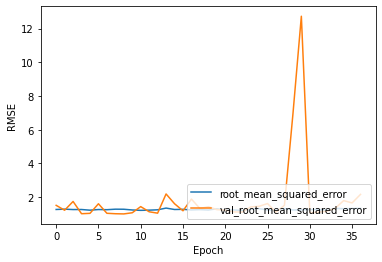

done.


In [29]:
X_train, X_test, y_train, y_test, pca = split_data(data, 
                                        pca=False, indices=indices,
                                        augmented=use_augmentation)
if force_retune: # or not os.path.exists('cnn_word_len.model'):
    tuner_len = kt.Hyperband(
        build_cnn_len,
        objective=kt.Objective('val_root_mean_squared_error',
                                    direction='min'),
        max_epochs=32,
        hyperband_iterations=2,
        overwrite=True
    )
    tuner_len.search(nn_inputs_len[indices[0]], y_train,
                       epochs=8,
                       validation_data=(nn_inputs_len[indices[1]],y_test))
    best_model_len = tuner_len.get_best_models(1)[0]
    best_hyperparameters_len = tuner_len.get_best_hyperparameters(1)[0]
    # save for later reuse
    with open('cnn_word_len.pkl', 'wb') as f:
        pkl.dump(best_hyperparameters_len, f)
    best_model_len.save('cnn_word_len.model')
    print(best_hyperparameters_len.values)
    print(best_model_len.summary())
else:
    if False: # for some reason, this doesn't work with kaggle notebooks :/
        print('Loading best_model_len from previous tuning..', flush=True, end='')
        with open('cnn_word_len.pkl', 'rb') as f:
            best_hyperparameters_len = pkl.load(f)
        best_model_len = models.load_model('cnn_word_len.model')
    else:
        print('Setting hyperparameters to best from previous tuning..', flush=True)
        if use_augmentation:
            best_hyperparameters_len_dict = {
                'conv_blocks': 4, 'filters_conv0': 14, 
                'kernel_conv0': 6, 'pooling0': 'none', 
                'dropout': 0.2, 'dense_blocks': 2, 
                'batch_norm': 1, 'dense0': 20, 
                'batch_norm_output': 1, 
                'learning_rate': 0.062226748473994786, 
                'filters_conv1': 12, 'kernel_conv1': 2, 
                'pooling1': 'none', 'filters_conv2': 8, 
                'kernel_conv2': 8, 'pooling2': 'none', 
                'filters_conv3': 10, 'kernel_conv3': 10, 
                'pooling3': 'none', 'dense1': 4, 
                'tuner/epochs': 32, 'tuner/initial_epoch': 11,
                'tuner/bracket': 1, 'tuner/round': 1, 
                'tuner/trial_id': 'd812d9866bd21f4026f92308febbe673'
            }
        else:
            best_hyperparameters_len_dict = {'conv_blocks': 3, 
                'filters_conv0': 12, 'kernel_conv0': 10, 
                'pooling0': 'avg', 'kernel_pool0': 4, 
                'dropout': 0.1, 'dense_blocks': 2, 
                'batch_norm': 1, 'dense0': 16, 
                'batch_norm_output': 0, 
                'learning_rate': 0.00474721153803654, 
                'filters_conv1': 6, 'kernel_conv1': 2, 
                'pooling1': 'none', 'filters_conv2': 4, 
                'kernel_conv2': 12, 'pooling2': 'avg', 
                'kernel_pool2': 4, 'dense1': 32, 
                'tuner/epochs': 32, 'tuner/initial_epoch': 11, 
                'tuner/bracket': 2, 'tuner/round': 2, 
                'tuner/trial_id': '27d7de1ebaf2eb206b40a8d999232b00'}
        best_model_len = fit_from_hp_dict(
            build_cnn_len, best_hyperparameters_len_dict, 
            nn_inputs_len, indices, y_train, y_test
        )
    print('done.')

In [30]:
data['cnn_word_len'] = best_model_len.predict(nn_inputs_len)
try_SGDR(data, indices=indices)

RMSE:  0.8030464767537705


In [31]:
print(best_model_len.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 200, 14)           98        
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 14)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 199, 12)           348       
_________________________________________________________________
dropout_3 (Dropout)          (None, 199, 12)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 192, 8)            776       
_________________________________________________________________
dropout_4 (Dropout)          (None, 192, 8)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 183, 10)          

Now, let us add word frequency data to the same neural network, to see if it improves this way...

In [32]:
# To feed the model, use the first WORDS_PER_EXCERPT words of the excerpt.
# If less is available, fill with empty

def nn_preprocess_len_freq (word_list, no_words=WORDS_PER_EXCERPT):
    # cut to the right length, normalize, extract word frequency
    res = [[len(x) * 1.0 / max_word_length, word_freq(x)] for x in word_list[:no_words]]
    if len(res) < no_words:
        res += [[0,0],] * (no_words - len(res))
    res = np.array(res, dtype=np.float)
    return res

nn_inputs_len_freq = np.vstack(data.word_list.apply(nn_preprocess_len_freq).to_numpy()).reshape((-1,WORDS_PER_EXCERPT,2))

In [33]:
nn_inputs_len_freq.shape

(2834, 205, 2)

In [34]:
# not bad, but we can do better with some hyperparameter tuning
# Note: this is overcounting a lot of combinations, but it does not seem possible to have the trials conditional in the tuner yet...

def build_cnn_len_freq (hp, augmented=use_augmentation):
    nn = models.Sequential()
    nn.add(layers.Input(shape=(WORDS_PER_EXCERPT,2)))
    num_conv_blocks = hp.Int('conv_blocks', 1,5)
    for i in range(num_conv_blocks):
        with hp.conditional_scope('conv_blocks', list(range(i+1,5+1))): # num > i
            nn.add(layers.Conv1D(hp.Int('filters_conv%i' % i,2,16,step=2),
                (min(nn.output_shape[1], hp.Int('kernel_conv%i' % i,2,16,step=2)),), 
                activation='relu'))
            pooling_choice = hp.Choice('pooling%i' % i, ['avg', 'max', 'none'])
            with hp.conditional_scope('pooling%i' % i, ['avg', 'max']):
                if pooling_choice == 'max':
                    nn.add(layers.MaxPooling1D(
                        (min(nn.output_shape[1], hp.Int('kernel_pool%i' % i,2,8,step=2)),)
                    ))
                elif pooling_choice == 'avg':
                    nn.add(layers.AveragePooling1D(
                        (min(nn.output_shape[1], hp.Int('kernel_pool%i' % i,2,8,step=2)),)
                    ))
            nn.add(layers.Dropout(hp.Float('dropout',0.,0.7,step=0.1)))
    nn.add(layers.Flatten())
    num_dense_blocks = hp.Int('dense_blocks', 1,3)
    for i in range(num_dense_blocks):
        with hp.conditional_scope('dense_blocks', list(range(i+1,3+1))): # num > i
            nn.add(layers.Dropout(hp.Float('dropout',0.,0.7,step=0.1)))
            if hp.Choice('batch_norm', [True, False]):
                nn.add(layers.BatchNormalization())
            nn.add(layers.Dense(hp.Int('dense%i' % i,4,64,step=4), activation='relu'))
    if hp.Choice('batch_norm_output', [True, False]):
        nn.add(layers.BatchNormalization())
    nn.add(layers.Dense(1))
    
    if augmented:
        loss = (lambda y1,y2,w=None : augmented_loss(tf.keras.losses.MeanSquaredError(), y1,y2,w))
    else:
        loss = tf.keras.losses.MeanSquaredError()

    nn.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4,0.3, sampling='log')),
               loss=loss,
               metrics=['RootMeanSquaredError'])
    
    return nn

Setting hyperparameters to best from previous tuning..
Epoch 1/1024
71/71 [==============================] - 3s 14ms/step - loss: 2.6358 - root_mean_squared_error: 1.3654 - val_loss: 1.4981 - val_root_mean_squared_error: 1.0514
Epoch 2/1024
71/71 [==============================] - 0s 7ms/step - loss: 1.7420 - root_mean_squared_error: 1.2275 - val_loss: 1.6821 - val_root_mean_squared_error: 1.0583
Epoch 3/1024
71/71 [==============================] - 0s 7ms/step - loss: 1.5201 - root_mean_squared_error: 1.2557 - val_loss: 1.5757 - val_root_mean_squared_error: 1.0661
Epoch 4/1024
71/71 [==============================] - 0s 7ms/step - loss: 1.2730 - root_mean_squared_error: 1.2460 - val_loss: 1.9240 - val_root_mean_squared_error: 1.0377
Epoch 5/1024
71/71 [==============================] - 0s 7ms/step - loss: 1.2500 - root_mean_squared_error: 1.2813 - val_loss: 2.2026 - val_root_mean_squared_error: 1.0441
Epoch 6/1024
71/71 [==============================] - 0s 7ms/step - loss: 1.1588 - r

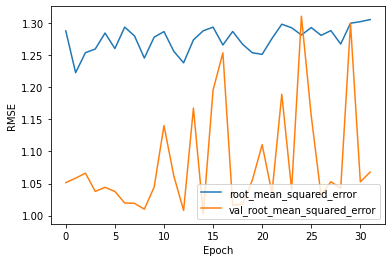

done.


In [35]:
if force_retune: # or not os.path.exists('cnn_word_len_freq.model'):
    tuner_len_freq = kt.Hyperband(
        build_cnn_len_freq,
        objective=kt.Objective('val_root_mean_squared_error',
                                    direction='min'),
        max_epochs=32,
        hyperband_iterations=2,
        overwrite=True
    )
    tuner_len_freq.search(nn_inputs_len_freq[indices[0]], y_train,
                   epochs=8,
                   validation_data=(nn_inputs_len_freq[indices[1]],y_test))
    best_model_len_freq = tuner_len_freq.get_best_models(1)[0]
    best_hyperparameters_len_freq = tuner_len_freq.get_best_hyperparameters(1)[0]
    # save for later reuse
    with open('cnn_word_len_freq.pkl', 'wb') as f:
        pkl.dump(best_hyperparameters_len_freq, f)
    best_model_len_freq.save('cnn_word_len_freq.model')
    print(best_hyperparameters_len_freq.values)
    print(best_model_len_freq.summary())
else:
    if False:
        print('Loading best_model_len from previous tuning..', flush=True, end='')
        with open('cnn_word_len_freq.pkl', 'rb') as f:
            best_hyperparameters_len_freq = pkl.load(f)
        best_model_len_freq = models.load_model('cnn_word_len_freq.model')
    else:
        print('Setting hyperparameters to best from previous tuning..', flush=True)
        if use_augmentation:
            best_hyperparameters_len_freq_dict = {
                'conv_blocks': 2, 'filters_conv0': 10, 
                'kernel_conv0': 14, 'pooling0': 'max', 
                'kernel_pool0': 4, 'dropout': 0.2, 
                'dense_blocks': 3, 'batch_norm': 1, 
                'dense0': 64, 'batch_norm_output': 1, 
                'learning_rate': 0.0009090024729461547, 
                'filters_conv1': 2, 'kernel_conv1': 14, 
                'pooling1': 'avg', 'kernel_pool1': 8, 
                'dense1': 32, 'dense2': 60, 'tuner/epochs': 32, 
                'tuner/initial_epoch': 0, 'tuner/bracket': 0, 
                'tuner/round': 0}
        else:
            best_hyperparameters_len_freq_dict = {
                'conv_blocks': 2, 'filters_conv0': 8, 
                'kernel_conv0': 10, 'pooling0': 'none', 
                'dropout': 0.2, 'dense_blocks': 2, 'batch_norm': 1, 
                'dense0': 12, 'batch_norm_output': 0, 
                'learning_rate': 0.018757792810801824, 
                'filters_conv1': 12, 'kernel_conv1': 6, 
                'pooling1': 'avg', 'kernel_pool1': 4, 'dense1': 4, 
                'tuner/epochs': 32, 'tuner/initial_epoch': 11, 
                'tuner/bracket': 1, 'tuner/round': 1, 
                'tuner/trial_id': '0011a1157813e370e78f8a237ca72049'}
        best_model_len_freq = fit_from_hp_dict(
            build_cnn_len_freq, best_hyperparameters_len_freq_dict, 
            nn_inputs_len_freq, indices, y_train, y_test
        )
    print('done.')

In [36]:
data['cnn_word_len+freq'] = best_model_len_freq.predict(nn_inputs_len_freq)
try_SGDR(data, indices=indices)

RMSE:  0.8008160574945826


In [37]:
print(best_model_len_freq.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 192, 10)           290       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 10)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 48, 10)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 35, 2)             282       
_________________________________________________________________
average_pooling1d (AveragePo (None, 4, 2)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 4, 2)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8)                

Well, simple counting will probably not get us much further. It's time to teach our model to understand the meaning of the text. For that, we will use word embeddings.

In [38]:
embedding_dim = 300 # 50, 100, 200, or 300; see the dataset instructions

# import word embeddings from the word2vec Kaggle dataset
word2vec = {}
with open('/kaggle/input/nlpword2vecembeddingspretrained/glove.6B.%id.txt' % embedding_dim, 'r') as f:
    for line in tqdm(f, total=400000):
        fields = line.split()
        word2vec[fields[0]] = np.array(fields[1:]).astype(np.float)
def word_vec (x):
    if x in word2vec.keys():
        return word2vec[x]
    else:
        return np.zeros(embedding_dim)

100%|██████████| 400000/400000 [01:54<00:00, 3508.12it/s]


In [39]:
# include word embedding data in our dataframe
data['word_embeddings'] = data.word_list.apply(lambda x : np.array([word_vec(y) for y in x]))
if 'word_embeddings' not in noTrain_columns:
    noTrain_columns += ['word_embeddings',]

In [40]:
# some useful statistics with word embeddings we get right away

# the topic of the excerpt
data[['mean_embedding%i' % i for i in range(embedding_dim)]] = pd.DataFrame(data.word_embeddings.apply(lambda x : np.mean(x, axis=0).tolist()).to_list())

# the variety of topics touched upon by the excerpt
data['stddev_embedding'] = data.word_embeddings.apply(lambda x : np.sum(np.std(x, axis=0)))

try_SGDR(data, indices=indices)

RMSE:  0.6472311236957493


In [41]:
# Does maximum distance between two word embeddings help at all?
def max_distance (emb_matrix):
    max_dist = 0.0
    n_vectors = emb_matrix.shape[0]
    for i_vec in range(n_vectors-1):
        max_dist = max(max_dist, np.max(np.sum((emb_matrix[(i_vec+1):] - emb_matrix[i_vec])**2, axis=1)))
    return np.sqrt(max_dist)

data['maxdist_embedding'] = data.word_embeddings.apply(max_distance)

try_SGDR(data, indices=indices)

RMSE:  0.6466037127301075


That's great so far! Ok, now let's connect the embeddings to a neural network.

In [42]:
# For now, let's use the first WORDS_PER_EXCERPT words again. We will expand it to include the entire excerpts later..

def nn_preprocess_emb (emb_matrix, no_words=WORDS_PER_EXCERPT):
    # cut or pad to the right length
    return np.concatenate([emb_matrix[:no_words,:], np.zeros([max(0,no_words-emb_matrix.shape[0]),emb_matrix.shape[1]])])

nn_inputs_emb = np.vstack(data.word_embeddings.apply(nn_preprocess_emb).to_numpy()).reshape((-1,WORDS_PER_EXCERPT,embedding_dim))

In [43]:
nn_inputs_emb.shape

(2834, 205, 300)

In [44]:
def build_cnn_emb (hp, augmented=use_augmentation):
    nn = models.Sequential()
    nn.add(layers.Input(shape=(WORDS_PER_EXCERPT,embedding_dim)))
    num_conv_blocks = hp.Int('conv_blocks', 0,5)
    for i in range(num_conv_blocks):
        with hp.conditional_scope('conv_blocks', list(range(i+1,5+1))): # num > i
            nn.add(layers.Conv1D(hp.Int('filters_conv%i' % i,2,16,step=2),
                (min(nn.output_shape[1], hp.Int('kernel_conv%i' % i,2,16,step=2)),), 
                activation='relu'))
            pooling_choice = hp.Choice('pooling%i' % i, ['avg', 'max', 'none'])
            with hp.conditional_scope('pooling%i' % i, ['avg', 'max']):
                if pooling_choice == 'max':
                    nn.add(layers.MaxPooling1D(
                        (min(nn.output_shape[1], hp.Int('kernel_pool%i' % i,2,8,step=2)),)
                    ))
                elif pooling_choice == 'avg':
                    nn.add(layers.AveragePooling1D(
                        (min(nn.output_shape[1], hp.Int('kernel_pool%i' % i,2,8,step=2)),)
                    ))
            nn.add(layers.Dropout(hp.Float('dropout',0.,0.7,step=0.1)))
    nn.add(layers.Flatten())
    num_dense_blocks = hp.Int('dense_blocks', 1,5)
    for i in range(num_dense_blocks):
        with hp.conditional_scope('dense_blocks', list(range(i+1,5+1))): # num > i
            nn.add(layers.Dropout(hp.Float('dropout',0.,0.7,step=0.1)))
            if hp.Choice('batch_norm', [True, False]):
                nn.add(layers.BatchNormalization())
            nn.add(layers.Dense(hp.Int('dense%i' % i,4,64,step=4), activation='relu'))
    if hp.Choice('batch_norm_output', [True, False]):
        nn.add(layers.BatchNormalization())
    nn.add(layers.Dense(1))
    
    if augmented:
        loss = (lambda y1,y2,w=None : augmented_loss(tf.keras.losses.MeanSquaredError(), y1,y2,w))
    else:
        loss = tf.keras.losses.MeanSquaredError()

    nn.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4,0.3, sampling='log')),
               loss=loss,
               metrics=['RootMeanSquaredError'])
    
    return nn

Setting hyperparameters to best from previous tuning..
Epoch 1/1024
71/71 [==============================] - 2s 17ms/step - loss: 1.9462 - root_mean_squared_error: 1.4650 - val_loss: 0.9571 - val_root_mean_squared_error: 1.3845
Epoch 2/1024
71/71 [==============================] - 1s 10ms/step - loss: 1.0957 - root_mean_squared_error: 1.2177 - val_loss: 1.0474 - val_root_mean_squared_error: 1.2697
Epoch 3/1024
71/71 [==============================] - 1s 10ms/step - loss: 1.0481 - root_mean_squared_error: 1.3243 - val_loss: 0.9141 - val_root_mean_squared_error: 1.1457
Epoch 4/1024
71/71 [==============================] - 1s 10ms/step - loss: 1.0497 - root_mean_squared_error: 1.1996 - val_loss: 0.9922 - val_root_mean_squared_error: 1.6056
Epoch 5/1024
71/71 [==============================] - 1s 10ms/step - loss: 1.2794 - root_mean_squared_error: 1.3986 - val_loss: 1.0862 - val_root_mean_squared_error: 1.0222
Epoch 6/1024
71/71 [==============================] - 1s 10ms/step - loss: 1.029

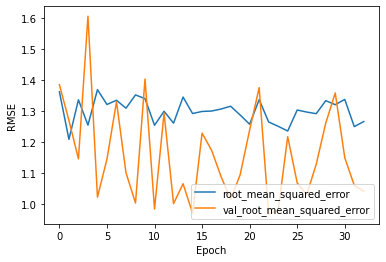

done.


In [45]:
if force_retune: # or not os.path.exists('cnn_word_emb.model'):
    tuner_emb = kt.Hyperband(
        build_cnn_emb,
        objective=kt.Objective('val_root_mean_squared_error',
                                    direction='min'),
        max_epochs=128,
        hyperband_iterations=2,
        overwrite=True
    )
    tuner_emb.search(nn_inputs_emb[indices[0]], y_train,
                   epochs=8,
                   validation_data=(nn_inputs_emb[indices[1]],y_test))
    best_model_emb = tuner_emb.get_best_models(1)[0]
    best_hyperparameters_emb = tuner_emb.get_best_hyperparameters(1)[0]
    # save for later reuse
    with open('cnn_word_emb.pkl', 'wb') as f:
        pkl.dump(best_hyperparameters_emb, f)
    best_model_emb.save('cnn_word_emb.model')
    print(best_hyperparameters_emb.values)
    print(best_model_emb.summary())
else:
    if False:
        print('Loading best_model_len from previous tuning..', flush=True, end='')
        with open('cnn_word_emb.pkl', 'rb') as f:
            best_hyperparameters_emb = pkl.load(f)
        best_model_emb = models.load_model('cnn_word_emb.model')
    else:
        print('Setting hyperparameters to best from previous tuning..', flush=True)
        if use_augmentation:
            best_hyperparameters_emb_dict = {
                'conv_blocks': 3, 'dense_blocks': 2, 
                'dropout': 0.30000000000000004, 'batch_norm': 0, 
                'dense0': 16, 'batch_norm_output': 1, 
                'learning_rate': 0.08197541995276879, 
                'filters_conv0': 2, 'kernel_conv0': 14, 
                'pooling0': 'max', 'kernel_pool0': 4, 
                'filters_conv1': 6, 'kernel_conv1': 12, 
                'pooling1': 'none', 'dense1': 44, 
                'filters_conv2': 14, 'kernel_conv2': 4, 
                'pooling2': 'avg', 'kernel_pool2': 2, 
                'tuner/epochs': 43, 'tuner/initial_epoch': 15, 
                'tuner/bracket': 2, 'tuner/round': 1, 
                'tuner/trial_id': 'dbed8e7c1c9d30298fe0430de255d50f'}
        else:
            best_hyperparameters_emb_dict = {
                'conv_blocks': 1, 'dense_blocks': 2, 
                'dropout': 0.30000000000000004, 'batch_norm': 0, 
                'dense0': 48, 'batch_norm_output': 1, 
                'learning_rate': 0.002693667798794543, 
                'dense1': 12, 'filters_conv0': 10, 'kernel_conv0': 4, 
                'pooling0': 'max', 'kernel_pool0': 6, 
                'tuner/epochs': 43, 'tuner/initial_epoch': 15, 
                'tuner/bracket': 4, 'tuner/round': 3, 
                'tuner/trial_id': '6ef193d541fe31f3ba90e45aedbaafdf'
            }
        best_model_emb = fit_from_hp_dict(
            build_cnn_emb, best_hyperparameters_emb_dict, 
            nn_inputs_emb, indices, y_train, y_test
        )
    print('done.')

In [46]:
data['cnn_word_embeddings'] = best_model_emb.predict(nn_inputs_emb)
try_SGDR(data, indices=indices)

RMSE:  0.7423511856127862


In [47]:
print(best_model_emb.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 192, 2)            8402      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 48, 2)             0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 48, 2)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 37, 6)             150       
_________________________________________________________________
dropout_14 (Dropout)         (None, 37, 6)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 34, 14)            350       
_________________________________________________________________
average_pooling1d_1 (Average (None, 17, 14)           

Hmm.. that's not too good.. A CNN might not be the best choice for text comprehension though.. Perhaps LSTM?

In [48]:
def build_lstm_emb (hp, augmented=use_augmentation):
    nn = models.Sequential()
    nn.add(layers.Input(shape=(WORDS_PER_EXCERPT,embedding_dim)))
    num_conv_blocks = hp.Int('lstm_blocks', 1,1)
    for i in range(num_conv_blocks):
        with hp.conditional_scope('lstm_blocks', list(range(i+1,5+1))): # num > i
            nn.add(layers.LSTM(
                hp.Int('lstm_units%i' % i, 8,128, sampling='log')
            ))
            nn.add(layers.Dropout(hp.Float('dropout',0.,0.7,step=0.1)))
    nn.add(layers.Flatten())
    num_dense_blocks = hp.Int('dense_blocks', 1,5)
    for i in range(num_dense_blocks):
        with hp.conditional_scope('dense_blocks', list(range(i+1,5+1))): # num > i
            nn.add(layers.Dropout(hp.Float('dropout',0.,0.7,step=0.1)))
            if hp.Choice('batch_norm', [True, False]):
                nn.add(layers.BatchNormalization())
            nn.add(layers.Dense(hp.Int('dense%i' % i,4,64,step=4), activation='relu'))
    if hp.Choice('batch_norm_output', [True, False]):
        nn.add(layers.BatchNormalization())
    nn.add(layers.Dense(1))
    
    if augmented:
        loss = (lambda y1,y2,w=None : augmented_loss(tf.keras.losses.MeanSquaredError(), y1,y2,w))
    else:
        loss = tf.keras.losses.MeanSquaredError()

    nn.compile(optimizer=tf.keras.optimizers.Adam(
                hp.Float('learning_rate', 1e-4,0.3, sampling='log')
               ),
               loss=loss,
               metrics=['RootMeanSquaredError'])
    
    return nn

Setting hyperparameters to best from previous tuning..
Epoch 1/1024
71/71 [==============================] - 3s 25ms/step - loss: 1.6161 - root_mean_squared_error: 1.3376 - val_loss: 1.5248 - val_root_mean_squared_error: 1.0430
Epoch 2/1024
71/71 [==============================] - 1s 18ms/step - loss: 1.1973 - root_mean_squared_error: 1.3359 - val_loss: 1.7321 - val_root_mean_squared_error: 1.0141
Epoch 3/1024
71/71 [==============================] - 1s 16ms/step - loss: 1.0585 - root_mean_squared_error: 1.3525 - val_loss: 1.1747 - val_root_mean_squared_error: 1.0846
Epoch 4/1024
71/71 [==============================] - 1s 16ms/step - loss: 0.7681 - root_mean_squared_error: 1.2648 - val_loss: 1.1380 - val_root_mean_squared_error: 1.0522
Epoch 5/1024
71/71 [==============================] - 1s 16ms/step - loss: 0.8145 - root_mean_squared_error: 1.2459 - val_loss: 0.9339 - val_root_mean_squared_error: 1.1051
Epoch 6/1024
71/71 [==============================] - 1s 16ms/step - loss: 0.837

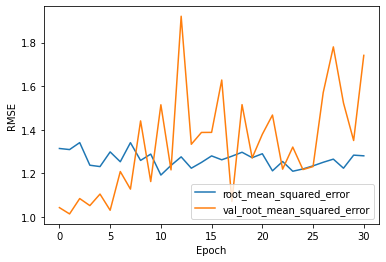

done.


In [49]:
if force_retune: # or not os.path.exists('lstm_word_emb.model'):
    tuner_emb = kt.Hyperband(
        build_lstm_emb,
        objective=kt.Objective('val_root_mean_squared_error',
                                    direction='min'),
        max_epochs=128,
        hyperband_iterations=2,
        overwrite=True
    )
    tuner_emb.search(nn_inputs_emb[indices[0]], y_train,
                   epochs=8,
                   validation_data=(nn_inputs_emb[indices[1]],y_test))
    best_model_emb_lstm = tuner_emb.get_best_models(1)[0]
    best_hyperparameters_emb_lstm = tuner_emb.get_best_hyperparameters(1)[0]
    # save for later reuse
    with open('lstm_word_emb.pkl', 'wb') as f:
        pkl.dump(best_hyperparameters_emb_lstm, f)
    best_model_emb_lstm.save('lstm_word_emb.model')
    print(best_hyperparameters_emb_lstm.values)
    print(best_model_emb_lstm.summary())
else:
    if False:
        print('Loading best_model_len from previous tuning..', flush=True, end='')
        with open('lstm_word_emb.pkl', 'rb') as f:
            best_hyperparameters_emb_lstm = pkl.load(f)
        best_model_emb_lstm = models.load_model('lstm_word_emb.model')
    else:
        print('Setting hyperparameters to best from previous tuning..', flush=True)
        if use_augmentation:
            best_hyperparameters_emb_lstm_dict = {
                'lstm_blocks': 1, 'lstm_units0': 55, 'dropout': 0.1, 
                'dense_blocks': 1, 'batch_norm': 1, 'dense0': 36, 
                'batch_norm_output': 0, 
                'learning_rate': 0.0036906795279518277, 
                'tuner/epochs': 128, 'tuner/initial_epoch': 0, 
                'tuner/bracket': 0, 'tuner/round': 0}
        else:
            best_hyperparameters_emb_lstm_dict = {
                'lstm_blocks': 1, 'lstm_units0': 66, 'dropout': 0.2, 
                'dense_blocks': 3, 'batch_norm': 1, 'dense0': 20, 
                'batch_norm_output': 1, 
                'learning_rate': 0.0022843219066342054, 'dense1': 60, 
                'dense2': 56, 'tuner/epochs': 43, 
                'tuner/initial_epoch': 0, 'tuner/bracket': 1, 
                'tuner/round': 0
            }
        best_model_emb_lstm = fit_from_hp_dict(
            build_lstm_emb, best_hyperparameters_emb_lstm_dict, 
            nn_inputs_emb, indices, y_train, y_test
        )
    print('done.')

In [50]:
data['lstm_word_embeddings'] = best_model_emb_lstm.predict(nn_inputs_emb)
try_SGDR(data, indices=indices)

RMSE:  0.7436989531327459


Maybe a bit better, but still rather disappointing..

Perhaps we could experiment a bit with the final classifier..

In [51]:
# first, find the best scaler to use with SGDR
scalers = {
    'Standard': StandardScaler(),
    'MinMax': MinMaxScaler(),
    'Robust': RobustScaler(),
    'PowerTransf': PowerTransformer(),
    'QuantileTransf': QuantileTransformer(),
    'QuantileTransfGauss': QuantileTransformer(output_distribution='normal'),
    'Normalizer': Normalizer()
}
if force_retune:
    X_train, X_test, y_train, y_test, pca = split_data(data, pca=False, indices=indices)
    print('Choosing the best scaler:')
    best_rmse = 1.0e9
    for scaler in scalers.keys():
        # test the parameter combination
        reg = make_pipeline(scalers[scaler],
                            SGDRegressor(
                                random_state=random_state
                            ))
        reg.fit(X_train, y_train)
        rmse = mean_squared_error(y_test, reg.predict(X_test), squared=False)
        print('  -- %s: rmse=%.2f' % (scaler, rmse))
        if rmse < best_rmse:
            best_scaler = scaler
            best_rmse = rmse
        del reg
    print('The best scaler for SGDR is %s, with best rmse=%.2f' % (best_scaler, best_rmse))
else:
    best_scaler = 'QuantileTransf'

In [52]:
@ignore_warnings(category=ConvergenceWarning)
def tune_SGDR (data, indices=None, output=False, best_scaler='QuantileTransf'):
    total_trials = 2*4*5*6*3*3
    print("Approx. no of trials to perform: %i" % total_trials)
    trial_no = 0
    best_rmse = 1.0e9
    best_parameters = None
    best_pca = None
    rmse = None
    for scaler in [best_scaler,]:
        for pca in [True, False]:
            X_train, X_test, y_train, y_test, _ = split_data(data, pca=pca, indices=indices)
            X_train_scaled = scalers[scaler].fit_transform(X_train)
            X_test_scaled = scalers[scaler].transform(X_test)
            for loss in ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']:
                for penalty in ['elasticnet',]:
                    for l1ratio in np.linspace(0.,1.,5):
                        for alpha in [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]:
                            if loss != 'squared_loss':
                                epsilons = [1e-3, 1e-2, 1e-1]
                            else:
                                epsilons = [0.1,] # ignored
                            for epsilon in epsilons:
                                for learning_rate in ['optimal', 'invscaling', 'adaptive']:
                                    #if learning_rate != 'optimal':
                                    #    eta0s = [1e-3, 1e-2, 1e-1]
                                    #else:
                                    eta0s = [0.01,]
                                    for eta0 in eta0s:
                                        #if learning_rate == 'invscaling':
                                        #    power_ts = np.linspace(0.01,1.0,4)
                                        #else:
                                        power_ts = [0.25,]
                                        for power_t in power_ts:
                                            hps = {
                                                'loss':loss, 'penalty':penalty,
                                                'l1_ratio':l1ratio, 'alpha':alpha,
                                                'epsilon':epsilon,
                                                'learning_rate':learning_rate,
                                                'eta0':eta0, 'power_t':power_t
                                            }
                                            # report on progress
                                            if trial_no % int(total_trials/100) == 0:
                                                print('\n %i %% done -----------------------------------------' % int(100.*trial_no/total_trials), flush=True)
                                                if trial_no % int(total_trials/20) == 0:
                                                    print('best rmse: ', best_rmse)
                                                    print('best hps: ', best_parameters)
                                                    print('best pca: ', best_pca)
                                                    print('best scaler: ', best_scaler)
                                                    print('------------------------------------------------------', flush=True)
                                                    print('current rmse: ', rmse)
                                                    print('current hps: ', hps)
                                                    print('current pca: ', pca)
                                                    print('current scaler: ', scaler)
                                                    print('------------------------------------------------------', flush=True)
                                            else:
                                                print('.', flush=True, end='')
                                            # test the parameter combination
                                            reg = SGDRegressor(
                                                **hps,
                                                random_state=random_state
                                            )
                                            reg.fit(X_train_scaled, y_train)
                                            rmse = mean_squared_error(y_test, reg.predict(X_test_scaled), squared=False)
                                            if rmse < best_rmse:
                                                best_parameters = hps
                                                best_rmse = rmse
                                                best_pca = pca
                                                best_scaler = scaler
                                            del reg
                                            trial_no += 1
    print("\nBest RMSE = %.2e" % best_rmse)
    print("  best hyperparameters:\n    ", best_parameters)
    print("  best pca: ", best_pca)
    print("  best scaler: ", best_scaler)
    if output:
        return best_parameters, best_pca, best_scaler, reg
    else:
        return best_parameters, best_pca, best_scaler

In [53]:
if force_retune:
    sgdr_best_hps, sgdr_best_pca, sgdr_best_scaler = tune_SGDR(data, indices=indices, best_scaler=best_scaler)
else:
    if use_augmentation:
        sgdr_best_hps = {
            'loss': 'epsilon_insensitive', 'penalty': 'elasticnet', 
            'l1_ratio': 0.0, 'alpha': 0.1, 'epsilon': 0.001, 
            'learning_rate': 'invscaling', 'eta0': 0.01, 'power_t': 0.25
        }
    else:
        sgdr_best_hps = {
            'loss': 'squared_epsilon_insensitive', 'penalty': 'elasticnet', 
            'l1_ratio': 0.0, 'alpha': 0.1, 'epsilon': 0.001, 
            'learning_rate': 'invscaling', 'eta0': 0.01, 'power_t': 0.25
        }
    sgdr_best_pca = False
    sgdr_best_scaler = best_scaler

In [54]:
def try_SGDR_opt (data, indices=None, output=False):
    X_train, X_test, y_train, y_test, pca = split_data(data, pca=sgdr_best_pca, indices=indices)
    reg = make_pipeline(scalers[sgdr_best_scaler],
                        SGDRegressor(
                            **sgdr_best_hps,
                            random_state=random_state
                        ))
    reg.fit(X_train, y_train)
    print("RMSE: ", mean_squared_error(y_test, reg.predict(X_test), squared=False))
    if output:
        return reg

try_SGDR_opt(data, indices=indices)

RMSE:  0.6236523258092488


In [55]:
# Let's also try a bunch of other classical ML regressors, first with default parameters
X_train, X_test, y_train, y_test, pca = split_data(data, pca=False, indices=indices)
X_all, _, y_all, _, pca = split_data(data, pca=False, indices=(data.index,[]))
ml_models = {
    'LR': LinearRegression(),
    'LGBM': LGBMRegressor(),
    'XGB': XGBRegressor(),
    'CatBoost': CatBoostRegressor(silent=True),
    'KernelRidge': KernelRidge(),
    'ElasticNet': ElasticNet(),
    'BayesianRidge': BayesianRidge(),
    'GradientBoosting': GradientBoostingRegressor(),
    'SVM': SVR(),
    'SGDR': SGDRegressor()
}
all_model_predictions = pd.DataFrame()
rmses = {}
best_model = None
best_rmse = 1.0e9
for name in ml_models.keys():
    if name not in rmses.keys() or force_retune:
        reg = make_pipeline(StandardScaler(),
            ml_models[name])
        reg.fit(X_train, y_train)
        rmses[name] = mean_squared_error(y_test, reg.predict(X_test), squared=False)
        if name != 'SGDR':
            all_model_predictions['prediction_'+name] = reg.predict(X_all)
        print('%s with scaler: RMSE = %.2f' % (name, rmses[name]))
        if (rmses[name] < best_rmse):
            best_model = name
            best_rmse = rmses[name]
        reg = make_pipeline(
            ml_models[name])
        reg.fit(X_train, y_train)
        name += '-unscaled'
        rmses[name] = mean_squared_error(y_test, reg.predict(X_test), squared=False)
        if name != 'SGDR-unscaled':
            all_model_predictions['prediction_'+name] = reg.predict(X_all)
        print('  -- without scaler: RMSE = %.2f' % (rmses[name]))
        if (rmses[name] < best_rmse):
            best_model = name
            best_rmse = rmses[name]
print("The best model is %s with rmse=%.2f." % (best_model, best_rmse))

LR with scaler: RMSE = 0.74
  -- without scaler: RMSE = 0.74
LGBM with scaler: RMSE = 0.72
  -- without scaler: RMSE = 0.72
XGB with scaler: RMSE = 0.74
  -- without scaler: RMSE = 0.74
CatBoost with scaler: RMSE = 0.71
  -- without scaler: RMSE = 0.70
KernelRidge with scaler: RMSE = 1.21
  -- without scaler: RMSE = 0.73
ElasticNet with scaler: RMSE = 0.84
  -- without scaler: RMSE = 0.84
BayesianRidge with scaler: RMSE = 0.72
  -- without scaler: RMSE = 0.72
GradientBoosting with scaler: RMSE = 0.72
  -- without scaler: RMSE = 0.72
SVM with scaler: RMSE = 0.65
  -- without scaler: RMSE = 0.86
SGDR with scaler: RMSE = 0.75
  -- without scaler: RMSE = 1032620031512323.50
The best model is SVM with rmse=0.65.


Oh, SVM seems to work best then. Let us optimize its hyperparameters then. But first, since we've done the work of training all these models, we can add their predictions to our dataframe too.

In [56]:
# Since we've done the work of training all these models, we can add their predictions to our dataframe too..
reg = try_SGDR_opt(data, indices=indices, output=True)
all_model_predictions['prediction_SGDR-opt'] = reg.predict(X_all)
#data = data.join(all_model_predictions[all_model_predictions.columns.difference(['prediction_SGDR', 'prediction_SGDR-unscaled', 'prediction_'+best_model])])

RMSE:  0.6236523258092488


In [57]:
# first, find the best scaler to use with SVM
scalers = {
    'Standard': StandardScaler(),
    'MinMax': MinMaxScaler(),
    'Robust': RobustScaler(),
    'PowerTransf': PowerTransformer(),
    'QuantileTransf': QuantileTransformer(),
    'QuantileTransfGauss': QuantileTransformer(output_distribution='normal'),
    'Normalizer': Normalizer()
}
if force_retune:
    X_train, X_test, y_train, y_test, pca = split_data(data, pca=False, indices=indices)
    print('Choosing the best scaler:')
    best_rmse = 1.0e9
    for scaler in scalers.keys():
        # test the parameter combination
        reg = make_pipeline(scalers[scaler],
                            SVR())
        reg.fit(X_train, y_train)
        rmse = mean_squared_error(y_test, reg.predict(X_test), squared=False)
        print('  -- %s: rmse=%.2f' % (scaler, rmse))
        if rmse < best_rmse:
            best_scaler = scaler
            best_rmse = rmse
        del reg
    print('The best scaler for SVM is %s, with best rmse=%.2f' % (best_scaler, best_rmse))
else:
    if use_augmentation:
        best_scaler = 'QuantileTransf'
    else:
        best_scaler = 'Robust'

In [58]:
# Tune the SVM model
@ignore_warnings(category=ConvergenceWarning)
def tune_SVM (data, indices=None, output=False, best_scaler='Robust'):
    total_trials = 4*3*3*2*5*3*2
    print("Approx. no of trials to perform: %i" % total_trials)
    trial_no = 0
    best_rmse = 1.0e9
    best_parameters = None
    best_pca = None
    rmse = None
    for scaler in [best_scaler,]:
        for pca in [True, False]:
            X_train, X_test, y_train, y_test, _ = split_data(data, pca=pca, indices=indices)
            X_train_scaled = scalers[scaler].fit_transform(X_train)
            X_test_scaled = scalers[scaler].transform(X_test)
            for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
                if kernel == 'poly':
                    degrees = [2,3,4]
                else:
                    degrees = [1,]
                for degree in degrees:
                    if kernel in ['rbf', 'poly', 'sigmoid']:
                        gammas = ['scale', 'auto']
                    else:
                        gammas = ['scale',]
                    for gamma in gammas:
                        for C in [1e-2, 1e-1, 1, 10, 100]:
                            for epsilon in [1e-3, 1e-2, 1e-1]:
                                for shrinking in [True, False]:
                                    hps = {
                                        'kernel':kernel, 'degree':degree,
                                        'gamma':gamma, 'C':C,
                                        'epsilon':epsilon, 'shrinking':shrinking,
                                        'max_iter':1e4
                                    }
                                    # report on progress
                                    if trial_no % int(total_trials/100) == 0:
                                        print('\n %i %% done -----------------------------------------' % int(100.*trial_no/total_trials), flush=True)
                                        if trial_no % int(total_trials/20) == 0:
                                            print('best rmse: ', best_rmse)
                                            print('best hps: ', best_parameters)
                                            print('best pca: ', best_pca)
                                            print('best scaler: ', best_scaler)
                                            print('------------------------------------------------------', flush=True)
                                            print('current rmse: ', rmse)
                                            print('current hps: ', hps)
                                            print('current pca: ', pca)
                                            print('current scaler: ', scaler)
                                            print('------------------------------------------------------', flush=True)
                                    else:
                                        print('.', flush=True, end='')
                                    # test the parameter combination
                                    reg = SVR(
                                        **hps
                                    )
                                    reg.fit(X_train_scaled, y_train)
                                    rmse = mean_squared_error(y_test, reg.predict(X_test_scaled), squared=False)
                                    if rmse < best_rmse:
                                        best_parameters = hps
                                        best_rmse = rmse
                                        best_pca = pca
                                        best_scaler = scaler
                                    del reg
                                    trial_no += 1
    print("\nBest RMSE = %.2e" % best_rmse)
    print("  best hyperparameters:\n    ", best_parameters)
    print("  best pca: ", best_pca)
    print("  best scaler: ", best_scaler)
    if output:
        return best_parameters, best_pca, best_scaler, reg
    else:
        return best_parameters, best_pca, best_scaler

In [59]:
if force_retune:
    svm_best_hps, svm_best_pca, svm_best_scaler = tune_SVM(data, indices=indices, best_scaler=best_scaler)
else:
    if use_augmentation:
        svm_best_hps = {'kernel': 'poly', 'degree': 3, 'gamma': 'auto', 'C': 10, 'epsilon': 0.1, 'shrinking': True}
    else:
        svm_best_hps = {'kernel': 'rbf', 'degree': 1, 'gamma': 'scale', 'C': 0.1, 'epsilon': 0.1, 'shrinking': True}
    svm_best_pca = False
    svm_best_scaler = best_scaler

In [60]:
def try_SVM_opt (data, indices=None, output=False):
    X_train, X_test, y_train, y_test, pca = split_data(data, pca=svm_best_pca, indices=indices)
    reg = make_pipeline(scalers[svm_best_scaler],
                        SVR(
                            **svm_best_hps
                        ))
    reg.fit(X_train, y_train)
    print("RMSE: ", mean_squared_error(y_test, reg.predict(X_test), squared=False))
    if output:
        return reg

reg = try_SVM_opt(data, indices=indices, output=True)
try_SGDR_opt(data, indices=indices)
all_model_predictions['prediction_SVM-opt'] = reg.predict(X_all)

RMSE:  0.6252495505213297
RMSE:  0.6236523258092488


In [61]:
# Does stacking models hierachically help? - not really
all_model_predictions['target'] = data['target']
try_SVM_opt(all_model_predictions, indices=indices)
try_SGDR_opt(all_model_predictions, indices=indices)

RMSE:  0.7628764678168224
RMSE:  0.7097938023748642


Finally, instead of a classical ML regressor, let us use a deep neural network for regression..

In [62]:
print(noTrain_columns)
cols_features = data.columns.difference(noTrain_columns)
print(cols_features)

no_features = len(cols_features)

nn_inputs_fin = data[cols_features].to_numpy()
print(nn_inputs_fin.shape)

['target', 'standard_error', 'excerpt', 'id', 'word_list', 'word_frequencies', 'word_embeddings']
Index(['cnn_word_embeddings', 'cnn_word_len', 'cnn_word_len+freq',
       'lstm_word_embeddings', 'max_characters_per_lineBreak',
       'max_characters_per_sentence', 'max_characters_per_word',
       'max_lineBreaks_per_sentence', 'max_sentences_per_lineBreak',
       'max_word_frequecy',
       ...
       'no_sentences', 'no_words', 'non_word_count', 'non_word_frequency',
       'number_count', 'number_frequency', 'punctuation_count',
       'punctuation_frequency', 'std_word_frequecy', 'stddev_embedding'],
      dtype='object', length=340)
(2834, 340)


In [63]:
def build_fin (hp):
    nn = models.Sequential()
    nn.add(layers.Input(shape=(no_features,)))
    nn.add(layers.Dense(hp.Int('dense_base',4,256, sampling='log'), activation='relu'))
    num_dense_blocks = hp.Int('dense_blocks', 1,7)
    for i in range(num_dense_blocks):
        with hp.conditional_scope('dense_blocks', list(range(i+1,7+1))): # num > i
            nn.add(layers.Dropout(hp.Float('dropout',0.,0.7,step=0.1)))
            if hp.Choice('batch_norm', [True, False]):
                nn.add(layers.BatchNormalization())
            nn.add(layers.Dense(hp.Int('dense%i' % i,4,256, sampling='log'), activation='relu'))
    if hp.Choice('batch_norm_output', [True, False]):
        nn.add(layers.BatchNormalization())
    nn.add(layers.Dense(1))

    nn.compile(optimizer=tf.keras.optimizers.Adam(
                hp.Float('learning_rate', 1e-4,0.3, sampling='log')
               ),
               loss=tf.keras.losses.MeanSquaredError(),
               metrics=['RootMeanSquaredError'])
    
    return nn

Setting hyperparameters to best from previous tuning..
Epoch 1/1024
71/71 [==============================] - 1s 7ms/step - loss: 2.0534 - root_mean_squared_error: 1.4268 - val_loss: 1.8503 - val_root_mean_squared_error: 1.3603
Epoch 2/1024
71/71 [==============================] - 0s 4ms/step - loss: 1.0189 - root_mean_squared_error: 1.0092 - val_loss: 1.0264 - val_root_mean_squared_error: 1.0131
Epoch 3/1024
71/71 [==============================] - 0s 4ms/step - loss: 0.9143 - root_mean_squared_error: 0.9561 - val_loss: 0.9888 - val_root_mean_squared_error: 0.9944
Epoch 4/1024
71/71 [==============================] - 0s 4ms/step - loss: 0.8773 - root_mean_squared_error: 0.9363 - val_loss: 0.7858 - val_root_mean_squared_error: 0.8864
Epoch 5/1024
71/71 [==============================] - 0s 4ms/step - loss: 0.8369 - root_mean_squared_error: 0.9147 - val_loss: 0.7324 - val_root_mean_squared_error: 0.8558
Epoch 6/1024
71/71 [==============================] - 0s 4ms/step - loss: 0.7907 - ro

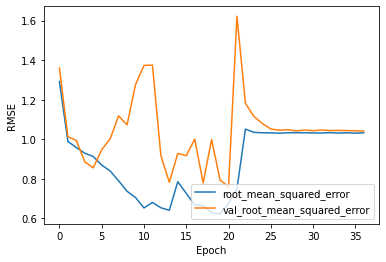

done.


In [64]:
if force_retune: # or not os.path.exists('lstm_word_emb.model'):
    tuner_fin = kt.Hyperband(
        build_fin,
        objective=kt.Objective('val_root_mean_squared_error',
                                    direction='min'),
        max_epochs=128,
        hyperband_iterations=2,
        overwrite=True
    )
    tuner_fin.search(nn_inputs_fin[indices[0]], y_train,
                   epochs=8,
                   validation_data=(nn_inputs_fin[indices[1]],y_test))
    best_model_fin = tuner_fin.get_best_models(1)[0]
    best_hyperparameters_fin = tuner_fin.get_best_hyperparameters(1)[0]
    # save for later reuse
    with open('fin.pkl', 'wb') as f:
        pkl.dump(best_hyperparameters_fin, f)
    best_model_fin.save('fin.model')
    print(best_hyperparameters_fin.values)
    print(best_model_fin.summary())
else:
    if False:
        print('Loading best_model_fin from previous tuning..', flush=True, end='')
        with open('fin.pkl', 'rb') as f:
            best_hyperparameters_fin = pkl.load(f)
        best_model_fin = models.load_model('fin.model')
    else:
        print('Setting hyperparameters to best from previous tuning..', flush=True)
        best_hyperparameters_fin_dict = {
            'dense_base': 28, 'dense_blocks': 3, 'dropout': 0.1, 
            'batch_norm': 0, 'dense0': 155, 'batch_norm_output': 1, 
            'learning_rate': 0.0031655607588791834, 'dense1': 35, 
            'dense2': 9, 'tuner/epochs': 128, 'tuner/initial_epoch': 43, 
            'tuner/bracket': 4, 'tuner/round': 4, 
            'tuner/trial_id': '9a74d2e1699f371fabb097cd347ff640'
        }
        best_model_fin = fit_from_hp_dict(
            build_fin, best_hyperparameters_fin_dict, 
            nn_inputs_fin, indices, y_train, y_test
        )
    print('done.')

Well, SGDR is still the best. Let's have one more look at our dataframe. Would adding or removing any of the columns help?

In [65]:
data['nn_final'] = best_model_fin.predict(nn_inputs_fin)
try_SGDR_opt(data, indices=indices)

RMSE:  0.6299845384601327


In [66]:
data = data.drop('nn_final', axis=1)
try_SGDR_opt(data, indices=indices)

RMSE:  0.6236523258092488


In [67]:
print(noTrain_columns)
cols_features = data.columns.difference(noTrain_columns)
print(cols_features)

['target', 'standard_error', 'excerpt', 'id', 'word_list', 'word_frequencies', 'word_embeddings']
Index(['cnn_word_embeddings', 'cnn_word_len', 'cnn_word_len+freq',
       'lstm_word_embeddings', 'max_characters_per_lineBreak',
       'max_characters_per_sentence', 'max_characters_per_word',
       'max_lineBreaks_per_sentence', 'max_sentences_per_lineBreak',
       'max_word_frequecy',
       ...
       'no_sentences', 'no_words', 'non_word_count', 'non_word_frequency',
       'number_count', 'number_frequency', 'punctuation_count',
       'punctuation_frequency', 'std_word_frequecy', 'stddev_embedding'],
      dtype='object', length=340)


There's a lot of columns with mean embeddings. Does removing them help?

In [68]:
noTrain_columns_orig = noTrain_columns.copy()
noTrain_columns += ['mean_embedding%i' % i for i in range(embedding_dim)]
try_SGDR_opt(data, indices=indices)

RMSE:  0.6661973524000326


Not really, let's keep them then

In [69]:
noTrain_columns = noTrain_columns_orig
try_SGDR_opt(data, indices=indices)

RMSE:  0.6236523258092488


We have some columns we don't use. Would they help?

In [70]:
data_expanded = data.copy()

In [71]:
# add word lengths
data_expanded = data_expanded.join(pd.DataFrame(np.squeeze(nn_inputs_len), columns=['word_len_%i' % i for i in range(WORDS_PER_EXCERPT)]))
print(data_expanded.columns)
try_SGDR_opt(data_expanded, indices=indices)

Index(['id', 'excerpt', 'target', 'standard_error', 'no_lineBreaks',
       'no_sentences', 'no_words', 'no_characters',
       'mean_sentences_per_lineBreak', 'mean_words_per_sentence',
       ...
       'word_len_195', 'word_len_196', 'word_len_197', 'word_len_198',
       'word_len_199', 'word_len_200', 'word_len_201', 'word_len_202',
       'word_len_203', 'word_len_204'],
      dtype='object', length=552)
RMSE:  0.6324469277689166


In [72]:
# add word frequencies
data_expanded = data_expanded.join(pd.DataFrame(np.squeeze(nn_inputs_len_freq[:,:,1]), columns=['word_freq_%i' % i for i in range(WORDS_PER_EXCERPT)]))
print(data_expanded.columns)
try_SGDR_opt(data_expanded, indices=indices)

Index(['id', 'excerpt', 'target', 'standard_error', 'no_lineBreaks',
       'no_sentences', 'no_words', 'no_characters',
       'mean_sentences_per_lineBreak', 'mean_words_per_sentence',
       ...
       'word_freq_195', 'word_freq_196', 'word_freq_197', 'word_freq_198',
       'word_freq_199', 'word_freq_200', 'word_freq_201', 'word_freq_202',
       'word_freq_203', 'word_freq_204'],
      dtype='object', length=757)
RMSE:  0.6828235646092556


In [73]:
# add word embeddings
embshape = list(nn_inputs_emb.shape)
dims_to_include = 16 # not enough memory to get the whole thing
embshape[2] = dims_to_include
data_expanded = data_expanded.join(pd.DataFrame(np.squeeze(nn_inputs_emb[:,:,:dims_to_include].reshape((embshape[0],embshape[1]*embshape[2]))), columns=['word_emb_%i' % i for i in range(WORDS_PER_EXCERPT*dims_to_include)]))
print(data_expanded.columns)
try_SGDR_opt(data_expanded, indices=indices)

Index(['id', 'excerpt', 'target', 'standard_error', 'no_lineBreaks',
       'no_sentences', 'no_words', 'no_characters',
       'mean_sentences_per_lineBreak', 'mean_words_per_sentence',
       ...
       'word_emb_3270', 'word_emb_3271', 'word_emb_3272', 'word_emb_3273',
       'word_emb_3274', 'word_emb_3275', 'word_emb_3276', 'word_emb_3277',
       'word_emb_3278', 'word_emb_3279'],
      dtype='object', length=4037)
RMSE:  0.870016359140427


In [74]:
try_SGDR(data_expanded, indices=indices)
try_SGDR(data_expanded, indices=indices, pca=True)
try_SVM_opt(data_expanded, indices=indices)

RMSE:  1576004861609.9868
RMSE:  0.7454026019950947
RMSE:  0.7150611051502979


Not much better. Well, it would appear we should end here, since the competition deadline is just in a few days. I will parse the complete model in another notebook, 2021_CommonLitReadability_final, for clarity. This was fun! ;)